In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch

df = pd.read_csv("/content/Demo-Graphite-Note-dataset-eCommerce-Orders.csv")

# Convert `created_at` to datetime
df['created_at'] = pd.to_datetime(df['created_at'], format='%d/%m/%Y')

# Remove rows with missing Customer IDs or Total Sales
df = df.dropna(subset=['user_id', 'total'])

# Remove negative or zero values in total sales
df = df[df['total'] > 0]

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21512 entries, 0 to 21511
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  21512 non-null  int64         
 1   InvoiceID           11976 non-null  object        
 2   InvoiceNumber       11976 non-null  object        
 3   user_id             21512 non-null  int64         
 4   order_type          21512 non-null  int64         
 5   ordernumber         21512 non-null  int64         
 6   shipping_method_id  21498 non-null  float64       
 7   payment_mothod_id   21512 non-null  int64         
 8   subtotal            21512 non-null  float64       
 9   vat                 21512 non-null  float64       
 10  shipping_charge     21512 non-null  int64         
 11  discount            21512 non-null  float64       
 12  total               21512 non-null  float64       
 13  status              21512 non-null  int64     

In [58]:
# Define snapshot date (latest date in dataset)
snapshot_date = df['created_at'].max()

# Compute RFM Metrics
rfm = df.groupby('user_id').agg({
    'created_at': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceID': 'count',  # Frequency
    'total': 'sum'  # Monetary
}).rename(columns={'created_at': 'Recency', 'InvoiceID': 'Frequency', 'total': 'Monetary'})

# Display RFM DataFrame
print(rfm.head())

         Recency  Frequency  Monetary
user_id                              
58           585          1    1913.3
61           284          0      99.0
100          367          6    1925.0
104            3          3   11159.0
107          585          2      75.0


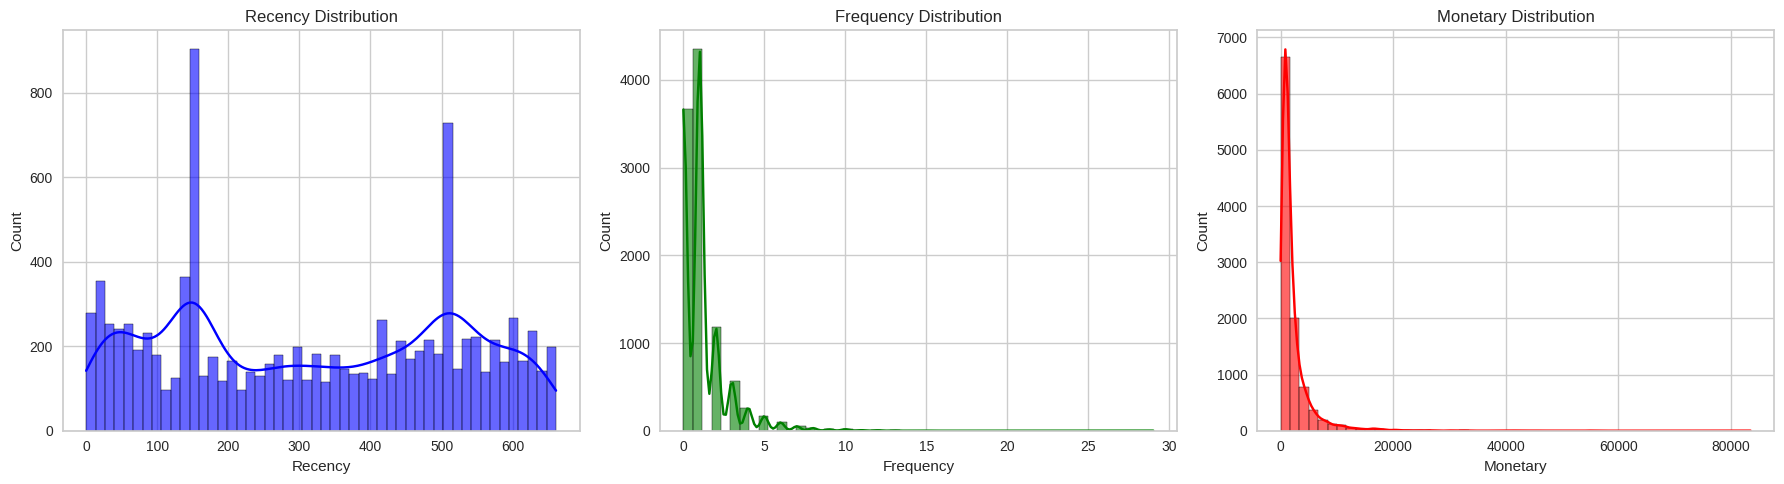

In [59]:
# Set figure size for better visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency Distribution
sns.histplot(rfm['Recency'], bins=50, kde=True, ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title("Recency Distribution")
axes[0].set_xlabel("Recency")
axes[0].set_ylabel("Count")

# Frequency Distribution
sns.histplot(rfm['Frequency'], bins=50, kde=True, ax=axes[1], color='green', alpha=0.6)
axes[1].set_title("Frequency Distribution")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Count")

# Monetary Distribution
sns.histplot(rfm['Monetary'], bins=50, kde=True, ax=axes[2], color='red', alpha=0.6)
axes[2].set_title("Monetary Distribution")
axes[2].set_xlabel("Monetary")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [60]:
# Normalize RFM values for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

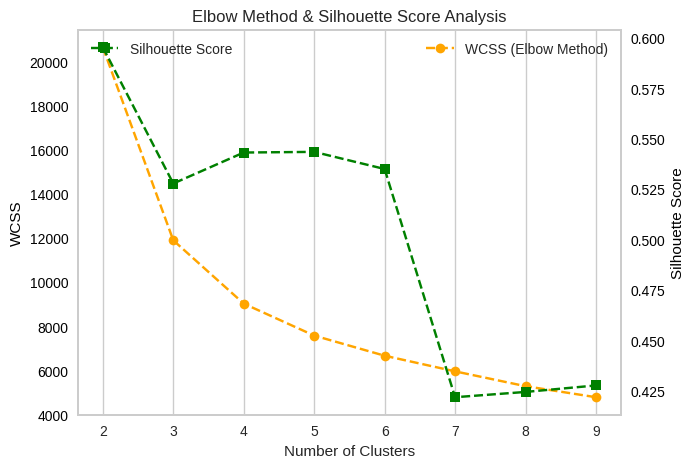

In [70]:
fig, ax1 = plt.subplots(figsize=(7, 5))

# Plot Elbow Method (WCSS) on left y-axis
ax1.plot(range(2, 10), wcss, marker='o', linestyle='--', color='orange', label='WCSS (Elbow Method)')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("WCSS", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(axis='y', linestyle='')

# Create second y-axis for Silhouette Score
ax2 = ax1.twinx()
ax2.plot(range(2, 10), silhouette_scores, marker='s', linestyle='--', color='green', label='Silhouette Score')
ax2.set_ylabel("Silhouette Score", color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.grid(axis='y', linestyle='')

plt.title("Elbow Method & Silhouette Score Analysis")
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')

plt.show()



In [48]:
# Apply K-Means with the best K from the Elbow/Silhouette method
optimal_k = 4  # Update based on the elbow method result
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Display clustered RFM data
print(rfm.groupby("Cluster").mean())


            Recency  Frequency      Monetary
Cluster                                     
0        509.445098   1.270838   1238.123731
1        149.191084   0.220878   1689.974404
2         89.571429   7.413534  22762.939699
3        207.650899   3.737938   6718.710066


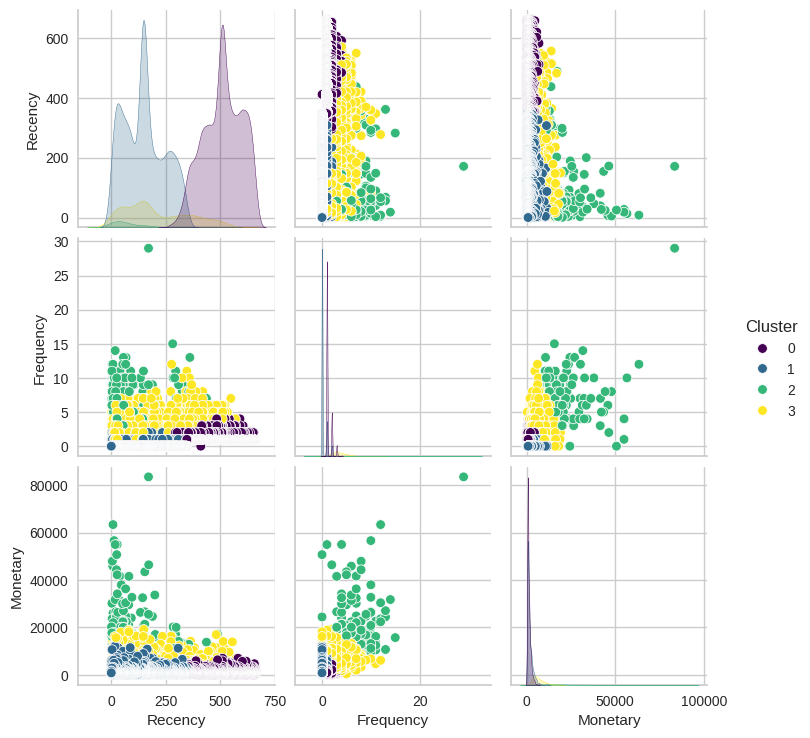

In [52]:
# Pairplot of Clusters
sns.pairplot(rfm, hue="Cluster", palette="viridis")
plt.show()

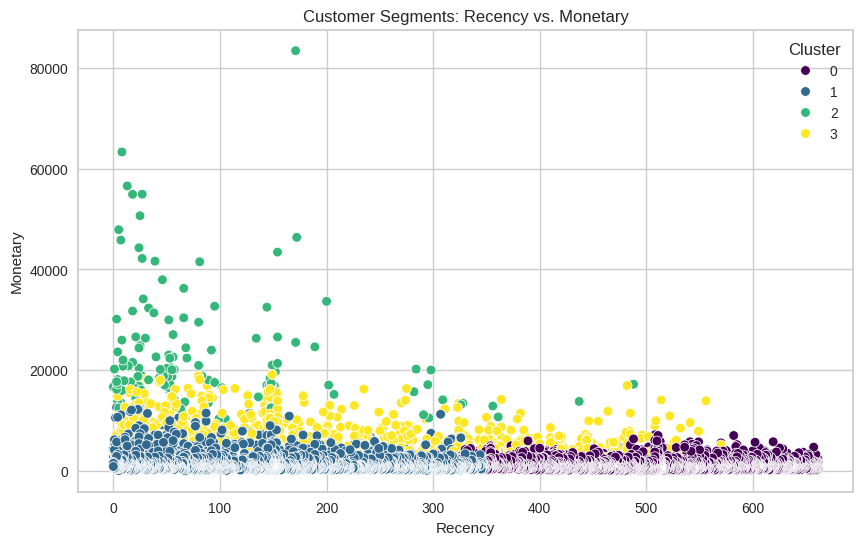

In [50]:
# Scatter plot for Recency vs. Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster", palette="viridis")
plt.title("Customer Segments: Recency vs. Monetary")
plt.show()

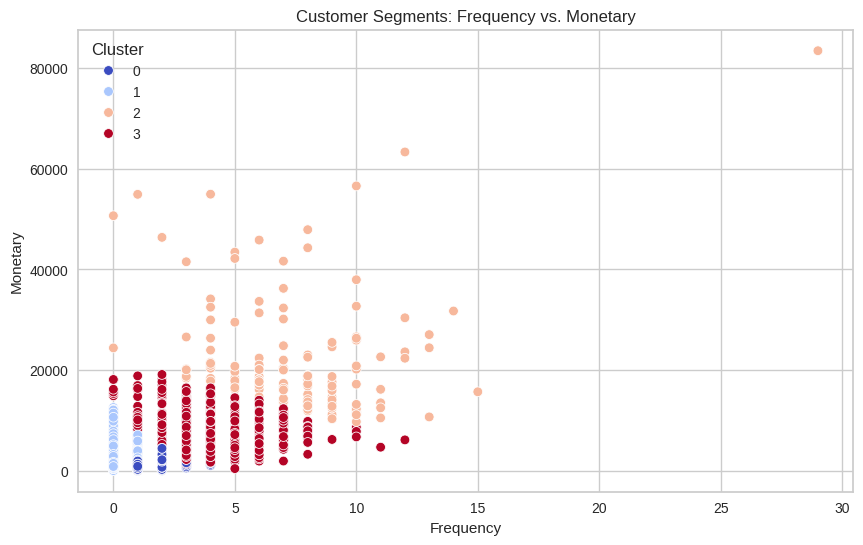

In [51]:
# Scatter plot for Frequency vs. Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="coolwarm")
plt.title("Customer Segments: Frequency vs. Monetary")
plt.show()

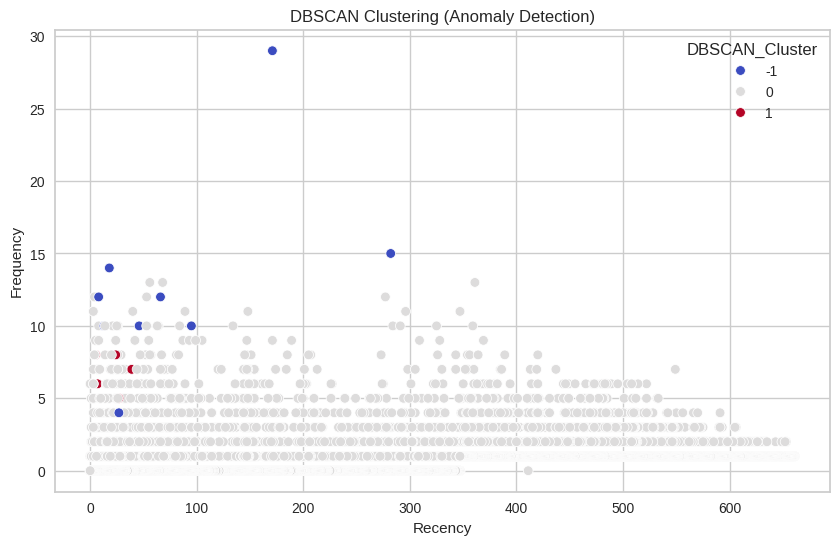

In [53]:
# Apply DBSCAN for anomaly detection
dbscan = DBSCAN(eps=1.5, min_samples=5).fit(rfm_scaled)
rfm['DBSCAN_Cluster'] = dbscan.labels_

# Plot DBSCAN Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x="Recency", y="Frequency", hue="DBSCAN_Cluster", palette="coolwarm")
plt.title("DBSCAN Clustering (Anomaly Detection)")
plt.show()

         Recency  Frequency  Monetary            Segment
user_id                                                 
58           585          1    1913.3    Needs Attention
61           284          0      99.0    Needs Attention
100          367          6    1925.0    Loyal Customers
104            3          3   11159.0     Best Customers
107          585          2      75.0  At-Risk Customers


<ipython-input-56-04718d3faccc>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Segment", data=rfm, palette="Set2", order=rfm['Segment'].value_counts().index)


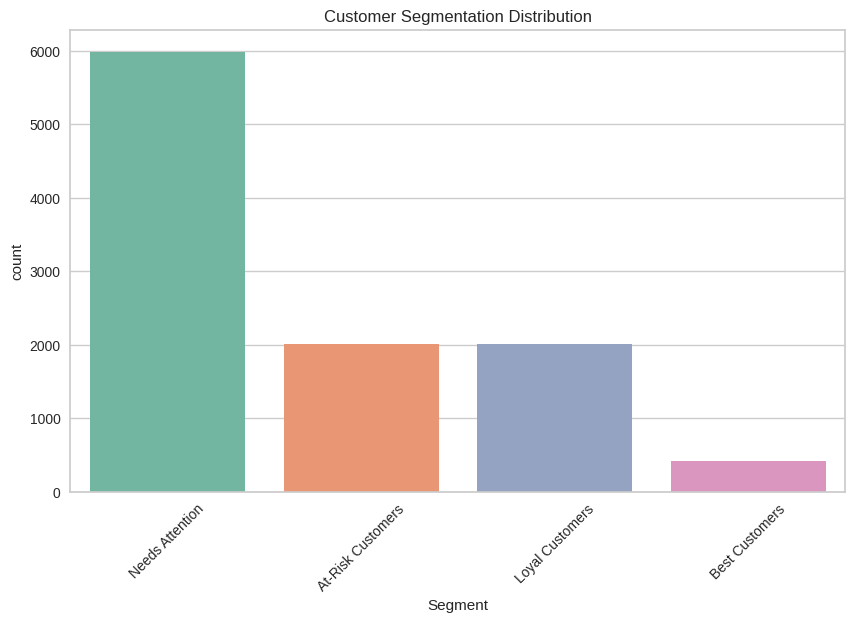

In [56]:
# Create RFM Segment Labels
def assign_label(row):
    if row['R_Score'] == 5 and row['F_Score'] == 5:
        return "Best Customers"
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return "Loyal Customers"
    elif row['R_Score'] <= 2 and row['F_Score'] >= 4:
        return "At-Risk Customers"
    else:
        return "Needs Attention"

# Create RFM Scores (1-5) with duplicate bin edge handling
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method="first"), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Assign Labels
rfm['Segment'] = rfm.apply(assign_label, axis=1)

# Display Final Segments
print(rfm[['Recency', 'Frequency', 'Monetary', 'Segment']].head())

# Plot Distribution of Customer Segments
plt.figure(figsize=(10, 6))
sns.countplot(x="Segment", data=rfm, palette="Set2", order=rfm['Segment'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Customer Segmentation Distribution")
plt.show()
